# Motion Tracker

Let's see how this goes.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import os
from PIL import Image
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from model import MotionDataset, PositionFinder, BoundingBoxFinder
import helper

# minmax, minmax_z = helper.get_minmax('train/input.csv', 'test/input.csv')
# print(minmax[0], minmax[1])
# print(minmax_z[0], minmax_z[1])

minmax, minmax_z = helper.get_minmax('train/input.csv', 'test/input.csv')
print(minmax[0], minmax[1])
# print(minmax_z[0], minmax_z[1])

img_width = 256
#randomly rotate or transform the images to help training
train_transforms = transforms.Compose([
#                                         transforms.RandomRotation(30),
#                                         transforms.RandomResizedCrop(256),
                                        transforms.Resize((img_width,img_width)),
                                       transforms.ToTensor()
#                                            ,transforms.Normalize([0.5, 0.5, 0.5], 
#                                                              [0.5, 0.5, 0.5])
                                       ,transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])
                                      ])

test_transforms = transforms.Compose([
                                       transforms.Resize((img_width,img_width)),
                                       transforms.ToTensor()
#                                         ,transforms.Normalize([0.5, 0.5, 0.5], 
#                                                              [0.5, 0.5, 0.5])
                                           ,transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])
                                      ])


motions = MotionDataset('train/input.csv', 'train', train_transforms, minmax, minmax_z)
trainloader = DataLoader(motions, batch_size=32, shuffle=True)
inp, output = next(iter(trainloader))

[[338.1732 317.2571 336.8706 ...   0.     512.     486.5926]
 [261.6963 307.0361 261.9155 ...   0.     422.2854 470.9323]
 [254.0521 298.7391 258.8464 ...   0.     377.51   455.2518]
 ...
 [270.2014 184.1364 269.7768 ... 156.4541 363.9916 492.8349]
 [259.9558 179.7241 259.4205 ... 173.397  375.3255 471.7738]
 [260.7242 188.6414 261.435  ... 158.9739 309.653  473.6201]]
0.0 512.0


## Prepare neural network model


In [2]:
device = 'cuda'
bmodel = BoundingBoxFinder(img_width)
model = PositionFinder(img_width)
print(model)

PositionFinder(
  (conv1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden1): Linear(in_features=131078, out_features=500, bias=True)
  (output): Linear(in_features=500, out_features=44, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [3]:
def my_loss(output, target):
    #mseloss (x - y) ^ 2
    #l1loss abs(x - y) 
#     output_2d = np.reshape(output, (-1, 2))
#     target_2d = np.reshape(target, (-1, 2))


    loss = torch.dist(output,target) # <---- result seemed quite good, and again with non cropped ones!

#     x = np.reshape(output.detach().cpu(), (-1, 2))
#     y = np.reshape(target.detach().cpu(), (-1, 2))
#     loss = torch.diag(torch.cdist(x,y)).mean()

#     loss = 0
#     for i in range(output.shape[0]):
#         for j in range(0, output.shape[1], 2):
#             loss += (torch.norm(output[i][j:j+2] - target[i][j:j+2]))
#     loss = loss / output.shape[1]
    return loss

## Train our model

best loss (L1Loss Sum, 0.003, conv4)
0.001 - 0.003


```
 Epoch 22/25) Training loss: 6.749771996027863, Test loss: 10.508017539978027
(Epoch 23/25) Training loss: 6.6242278638523295, Test loss: 10.340709686279297
(Epoch 24/25) Training loss: 6.520543051754824, Test loss: 10.395054817199707
```

input contains image (human centered) height, isFacingForward

output contains (x,y) coordinates for 22 body parts
 


## 1. Boundaries detection


In [4]:
from torch import optim, nn
# # Optimizers require the parameters to optimize and a learning rate
# optimizer = optim.SGD(bmodel.parameters(), lr=0.0007, momentum=0.7)
# criterion = nn.L1Loss(reduction='sum') 
# device = 'cuda'
# bmodel.to(device)
# train_losses, test_losses = [], []
# epochs = 5

# for e in range(epochs):
#     running_loss = 0
#     for images, details, targets, confidences, boundaries in trainloader:
#         images, boundaries = images.to(device), boundaries.to(device)
#         #1. forward pass
#         ps = bmodel.forward(images)
#         #2. calculate loss
#         loss = criterion(ps, boundaries)
#         #0. Clear the gradients, do this because gradients are accumulated
#         optimizer.zero_grad()

#         #3. run backward propagation
#         loss.backward()

#         # 4. Take an update step and few the new weights
#         optimizer.step()
#         running_loss += loss.item()
# #         print(loss.item())
#     else:
#         test_loss = 0
#         accuracy = 0
        
#         # Turn off gradients for validation, saves memory and computations
#         with torch.no_grad():
#             bmodel.eval()
#             for images, details, targets, confidences, boundaries in testloader:
#                 images, boundaries = images.to(device), boundaries.to(device)
#                 ps = bmodel.forward(images)
#                 test_loss += my_loss(ps, boundaries)

        
#         bmodel.train()
        
#         test_loss = test_loss/len(testloader)
#         train_loss = running_loss/len(trainloader)
#         train_losses.append(train_loss)
#         test_losses.append(test_loss)
#         print(f"(Epoch {e}/{epochs}) Training loss: {train_loss}, Test loss: {test_loss}")
        
# PATH = 'bmodel.m'
# torch.save(bmodel.state_dict(), PATH)

In [5]:
bmodel = BoundingBoxFinder(img_width)
bmodel.load_state_dict(torch.load('bmodel.m'))
train_transforms = transforms.Compose([
                                       transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])
                                      ])

motions = MotionDataset('train/input.csv', 'train', train_transforms, minmax, minmax_z)
trainloader = DataLoader(motions, batch_size=32, shuffle=False)

bboxes = []
bmodel.to(device)

# transforms.functional.crop(img: torch.Tensor, top: int, left: int, height: int, width: int)

BoundingBoxFinder(
  (conv1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden1): Linear(in_features=262144, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

0
tensor([0.3650, 0.3826, 0.3614, 0.3376, 0.3647, 0.2841, 0.3737, 0.2219, 0.3899,
        0.1505, 0.4113, 0.1186, 0.4141, 0.1699, 0.4516, 0.1952, 0.4719, 0.2561,
        0.5543, 0.2431, 0.4032, 0.4041, 0.4678, 0.5741, 0.5142, 0.7249, 0.5350,
        0.7890, 0.3586, 0.1511, 0.3138, 0.1379, 0.1877, 0.1734, 0.1620, 0.0971,
        0.3250, 0.4099, 0.3417, 0.5893, 0.2767, 0.7617, 0.2739, 0.8609])
tensor(-2.1179) tensor(2.4483)
tensor(0.0318) tensor(0.9989)


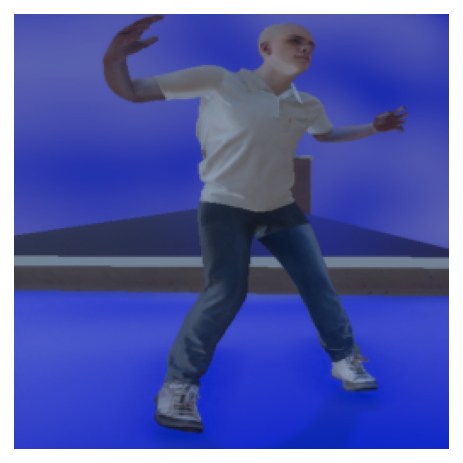

In [6]:
from model import MotionDataset
train_transforms = transforms.Compose([
                                       transforms.Resize((img_width,img_width)),
                                       transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])
                                      ])
print(len(bboxes))
motions = MotionDataset('train/input.csv', 'train', train_transforms, minmax, minmax_z, bmodel=bmodel)
trainloader = DataLoader(motions, batch_size=32, shuffle=True)
inp, output = next(iter(trainloader))
helper.imshow(inp["images"][15])
print(output["positions"][15])
print(inp["images"].min(), inp["images"].max())
print(output["positions"].min(), output["positions"].max())

motions_test = MotionDataset('test/input.csv', 'test', test_transforms, minmax, minmax_z, bmodel=bmodel)
testloader = torch.utils.data.DataLoader(motions_test, batch_size=32, shuffle=True)

In [7]:
from torch import optim, nn
# Optimizers require the parameters to optimize and a learning rate
# optimizer = optim.SGD(model.parameters(), lr=0.00002, momentum=0.7)
optimizer = optim.SGD(model.parameters(), lr=0.0002)
criterion = nn.MSELoss(reduction='sum') 
# criterion = nn.L1Loss(reduction='sum') 
bceloss = nn.BCELoss()
bceloss_w = 4
print(torch.cuda.get_device_name(0))
train_losses, test_losses = [], []
epochs = 16
print(model)

model.to(device)

for e in range(epochs):
    running_loss = 0
    for inp, output in trainloader:
        for k in inp:
            inp[k] = inp[k].to(device)
        for k in output:
            output[k] = output[k].to(device)
        
        #1. forward pass
        ps = model.forward(inp["images"], inp["details"], inp["bboxes"])
#       print(ps2, confidences)
#       print(np.min(ps.cpu().detach().numpy()), np.min(targets.cpu().detach().numpy()))
#       print(np.max(ps.cpu().detach().numpy()), np.max(targets.cpu().detach().numpy()))

        #2. calculate loss
#         print(ps[0], positions[0])
        loss = my_loss(ps, output["positions"])
        #0. Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()

        #3. run backward propagation
        loss.backward()

        # 4. Take an update step and few the new weights
        optimizer.step()
        running_loss += loss.item()
#         print(loss.item())
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for inp, output in testloader:
                for k in inp:
                    inp[k] = inp[k].to(device)
                for k in output:
                    output[k] = output[k].to(device)
                ps = model.forward(inp["images"], inp["details"], inp["bboxes"])
#                 _loss = criterion(ps, targets)
#                 _bceloss = bceloss(ps2, confidences) / bceloss_w
#                 test_loss += _loss + _bceloss
                test_loss += my_loss(ps, output["positions"])

        
        model.train()
        
        test_loss = test_loss/len(testloader)
        train_loss = running_loss/len(trainloader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"(Epoch {e+1}/{epochs}) Training loss: {train_loss}, Test loss: {test_loss}")
        
PATH = 'model.m'
torch.save(model.state_dict(), PATH)

NVIDIA GeForce RTX 3070
PositionFinder(
  (conv1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden1): Linear(in_features=131078, out_features=500, bias=True)
  (output): Linear(in_features=500, out_features=44, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


d:\Users\bihta\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(Epoch 1/16) Training loss: 10.735684904185208, Test loss: 5.722471714019775
(Epoch 2/16) Training loss: 5.330685171214017, Test loss: 2.7133233547210693
(Epoch 3/16) Training loss: 4.559404118494554, Test loss: 2.626617193222046
(Epoch 4/16) Training loss: 4.261055913838473, Test loss: 2.4119386672973633
(Epoch 5/16) Training loss: 4.050133342092687, Test loss: 2.2856650352478027
(Epoch 6/16) Training loss: 3.9174338579177856, Test loss: 2.3082311153411865
(Epoch 7/16) Training loss: 3.810384766622023, Test loss: 2.221112012863159
(Epoch 8/16) Training loss: 3.7055662762035024, Test loss: 2.2589523792266846
(Epoch 9/16) Training loss: 3.6166467558253896, Test loss: 2.1836729049682617
(Epoch 10/16) Training loss: 3.579090627756986, Test loss: 2.1657228469848633
(Epoch 11/16) Training loss: 3.5135965022173794, Test loss: 2.138792037963867
(Epoch 12/16) Training loss: 3.47702772508968, Test loss: 2.1600630283355713
(Epoch 13/16) Training loss: 3.4085769436576148, Test loss: 2.18648362159

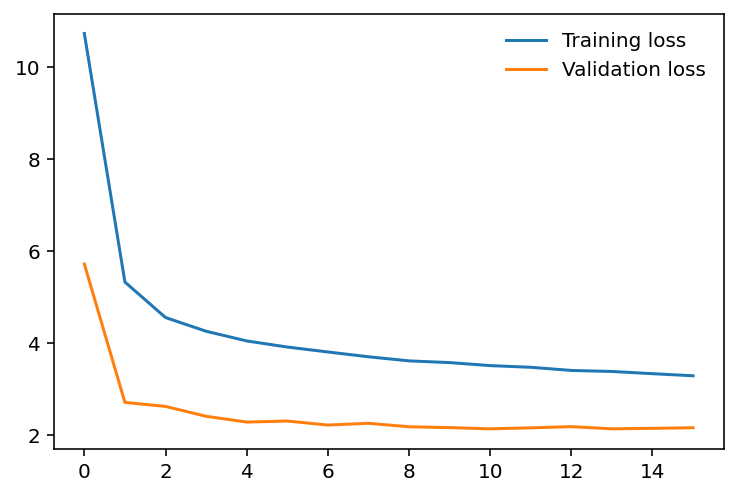

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
test_losses = [test_loss.to('cpu') for test_loss in test_losses]
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Use our model

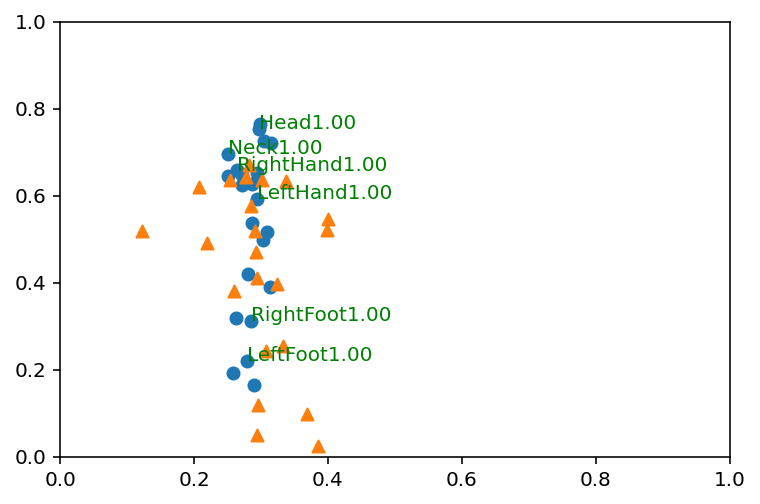

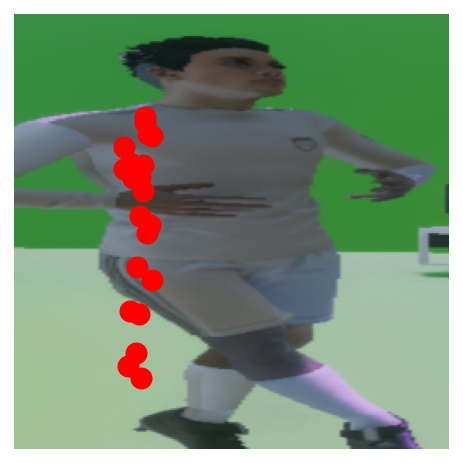

In [15]:
%matplotlib inline
# test_transform = transforms.Compose([transforms.Resize((img_width,img_width)),
#                                 transforms.ToTensor()])
import helper
motions_test = MotionDataset('test/input.csv', 'test', test_transforms, minmax, minmax_z, bmodel=bmodel)
testloader = torch.utils.data.DataLoader(motions_test, batch_size=16, shuffle=True)
inp, output = next(iter(testloader))

model = PositionFinder(img_width)
model.load_state_dict(torch.load('model.m'))

# img = images[0].view(1, 195075)
# img = torch.zeros(1,120000) + 222

positions = []
positions_expected = []
# Turn off gradients to speed up this part
with torch.no_grad():
    for k in inp:
        inp[k] = inp[k].to('cpu')
    for k in output:
        output[k] = output[k].to('cpu')
    
    logps = model.forward(inp["images"], inp["details"], inp["bboxes"])
    logps_denormalized = logps 
    labels_denormalized = output["positions"]
    
    for body_index in range(22):
        xyz = []
        xyz_e = []
        for pos_index in range(2):
            xyz.append(logps_denormalized[0][body_index*2+pos_index])
            xyz_e.append(labels_denormalized[0][body_index*2+pos_index])
        positions.append(xyz)
        positions_expected.append(xyz_e)
#     print(list(model.parameters()))

positions = np.array(positions)
positions_expected = np.array(positions_expected)
fig = plt.figure()
ax = plt.axes()

# zdata = positions.T[1]
xdata = positions.T[0]
ydata = positions.T[1]
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.scatter(xdata, [1 - y for y in ydata]);

# zdata_e = positions_expected.T[1]
xdata_e = positions_expected.T[0]
ydata_e = positions_expected.T[1]
ax.scatter(xdata_e, [1 - y for y in ydata_e], marker='^')
helper.imshow(inp["images"][0], xdata=xdata, ydata=ydata)

for i, pos in enumerate(positions):
    label = None
    if i == 4:
        label = "Neck"
    elif i == 5:
        label = "Head"
    elif i == 9:
        label = "LeftHand"
    elif i == 12:
        label = "LeftFoot"
    elif i == 17:
        label = "RightHand"
    elif i == 20:
        label = "RightFoot"
    if label is not None:
        label = label + "{:.2f}".format(output["confidences"][0][i].item())
        ax.text(pos[0], 1 - pos[1], label, None, color="green")

Total distance 1.6300526


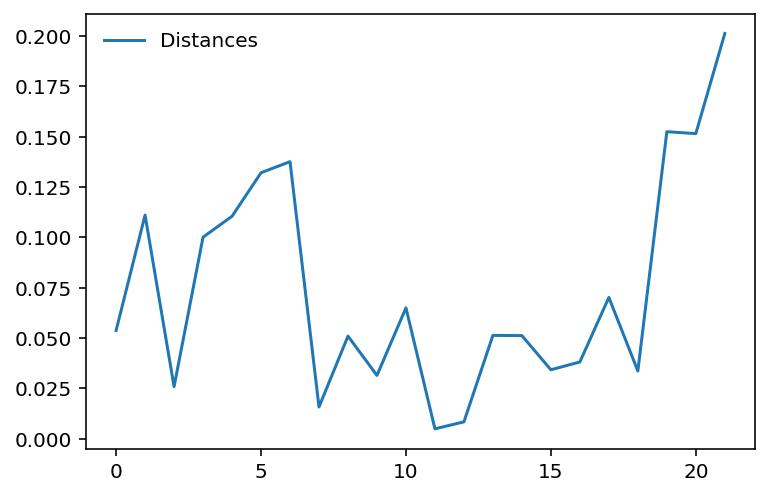

In [13]:
distances = []
for i, pos in enumerate(positions):
    pos_exp = positions_expected[i]
    
    dist = np.linalg.norm(pos_exp-pos)
    distances.append(dist)

print("Total distance", np.array(distances).sum())
plt.plot(distances, label='Distances')
plt.legend(frameon=False)

## 

In [11]:
motions_test2 = MotionDataset('test2/input.csv', 'test2', test_transforms, minmax, minmax_z)
testloader2 = torch.utils.data.DataLoader(motions_test2, batch_size=3, shuffle=True)